## Extension of the 10% pool in paper 1

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import scipy.stats 

import matplotlib.gridspec as gspec

import os
import sys
import warnings
warnings.filterwarnings("ignore")

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
sns.set_context('notebook')
sns.set_style('white')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/ptracersGlob.nc'

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)
 

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

In [5]:
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

for ii in range(len(records)):
    print(ii,records[ii].name)
select_rec = [0,2,38,49,33,31,5,10,18]
    
records2 = [records[0],
            records[38],
            records[49],
            records[33],
            records[31],
            records[5],
            records[10],
            records[18],
            ]

linestyles=['solid','solid','solid','dashed','dotted','solid','solid','solid']

recordsNoC2 = [recordsNoC[0],
               recordsNoC[38],
               recordsNoC[49],
               recordsNoC[33],
               recordsNoC[31],
               recordsNoC[5],
               recordsNoC[10],
               recordsNoC[18],
               ]
#records2 = records
#recordsNoC2 = recordsNoC

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run79
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
11 3DVISC_run01
12 3DVISC_run02
13 3DVISC_run04
14 3DVISC_run03
15 3DVISC_run05
16 3DVISC_run06
17 LOWER_BF_run01
18 LOW_BF_run01
19 LOWEST_BF_run01
20 LOWEST_BF_run03
21 LOWEST_BF_run05
22 LOWEST_BF_run07
23 LOWEST_BF_run11
24 3DVISC_REALISTIC_run01
25 3DVISC_REALISTIC_run02
26 3DVISC_REALISTIC_run03
27 3DVISC_REALISTIC_run05
28 3DVISC_REALISTIC_run06
29 3DVISC_REALISTIC_run07
30 3DVISC_REALISTIC_run08
31 3DVISC_REALISTIC_run09
32 3DVISC_REALISTIC_run10
33 3DVISC_REALISTIC_run11
34 3DVISC_REALISTIC_run12
35 3DVISC_REALISTIC_run13
36 3DVISC_REALISTIC_run14
37 3DVISC_REALISTIC_run15
38 3DVISC_REALISTIC_run16
39 3DVISC_REALISTIC_run17
40 3DVISC_REALISTIC_run18
41 3DVISC_REALISTIC_run19
42 3DVISC_REALISTIC_run20
43 3DVISC_REALISTIC_run21
44 3DVISC_REALISTIC_run22
45 3DVISC_REALISTIC_run23
46 3DVISC_REALISTIC_run24


In [6]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,cont_value,col, lines='solid'):
    
    #ax.axvline(X[xind_CS]/1000, color = '0.5', linestyle = '-', linewidth = 1)
    ax.axhline(Y[yind_AS]/1000, color = '0.5', linestyle = ':', linewidth = 1)
    
    BAC = ConcFilt[yslice,xslice]
    
   
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[cont_value], 
                      colors=col, linestyles=lines,
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    
def PlotAS(ax,Conc,xsl,zsl,cont_value,col, lines='solid'):
    print(np.shape(X[xsl]/1000),np.shape(Z[zsl]), np.shape(Conc))
   
    mesh = ax.contour(X[xsl]/1000,Z[zsl],Conc,[cont_value], 
                      colors=col,linestyles=lines, 
                      )
    
    ax.plot(X[xsl]/1000,-Depth[yind_AS,xsl],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    
def PlotCS(ax,Conc,yslice,zslice,cont_value,col):
    
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[cont_value], 
                      colors=col, 
                      )
    
    ax.plot(Y[yslice]/1000,-Depth[yslice_CS, xind_CS],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)

In [7]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
yind_AS = 275
xind_CS = 260

xslice_AS = slice(120,500)
yslice_CS = slice(227,360)
zslice_AS = slice(0,30)

yslice = slice(225,360)
xslice = slice(120,500)

In [8]:
for rec in records2:
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    with Dataset(ptracers_file, 'r') as nbl:
        
        ConcArea, rec.concBOT, Area = BottomConc(np.mean(nbl.variables['Tr1'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
        rec.concAS = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        rec.concCS = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )

done with tracer CNTDIFF run38
done with tracer 3DVISC_REALISTIC run16
done with tracer 3DVISC_REALISTIC run27
done with tracer 3DVISC_REALISTIC run11
done with tracer 3DVISC_REALISTIC run09
done with tracer CNTDIFF run75
done with tracer CNTDIFF run71
done with tracer LOW_BF run01


In [9]:
for rec in records2:
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    with Dataset(ptracers_file, 'r') as nbl:
        
        ConcArea, rec.concBOT_ini, Area = BottomConc(nbl.variables['Tr1'][0,:,:,:],hFacC,rA,Depth)
        rec.concAS_ini = np.ma.array(nbl.variables['Tr1'][0,zslice_AS,yind_AS,xslice_AS],
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        rec.concCS_ini = np.ma.array(nbl.variables['Tr1'][0,zslice_AS,yslice_CS,xind_CS],
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )


done with tracer CNTDIFF run38
done with tracer 3DVISC_REALISTIC run16
done with tracer 3DVISC_REALISTIC run27
done with tracer 3DVISC_REALISTIC run11
done with tracer 3DVISC_REALISTIC run09
done with tracer CNTDIFF run75
done with tracer CNTDIFF run71
done with tracer LOW_BF run01


In [10]:
for rec, recNoC in zip(records2, recordsNoC2):
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            ConcArea, rec.concBOT_anom, Area = BottomConc(np.nanmean(nbl.variables['Tr1'][8:18,:,:,:]-
                                                          noc.variables['Tr1'][8:18,:,:,:],axis=0),hFacC,rA,Depth)
            rec.concAS_anom = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS]-
                                                     noc.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                          mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
            rec.concCS_anom = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS]-
                                                 noc.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                          mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )

done with tracer CNTDIFF run38
done with tracer 3DVISC_REALISTIC run16
done with tracer 3DVISC_REALISTIC run27
done with tracer 3DVISC_REALISTIC run11
done with tracer 3DVISC_REALISTIC run09
done with tracer CNTDIFF run75
done with tracer CNTDIFF run71
done with tracer LOW_BF run01


## Bottom concentrations

In [11]:
for rec, recNoC in zip(records2, recordsNoC2):
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    rec.BCA = np.empty((nt,ny,nx))
    rec.BC = np.empty((nt,ny,nx))
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            for ii in range(nt):
                rec.BCA[ii,:,:], dummy, rec.AreaTot1 = BottomConc(noc.variables['Tr1'][ii,:,:,:], hFacCNoC,rA,Depth)
                rec.BC[ii,:,:], dummy, rec.AreaTot2 = BottomConc(nbl.variables['Tr1'][ii,:,:,:],hFacCNoC,rA,Depth)


(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


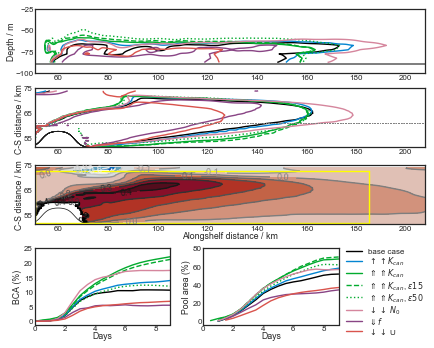

In [12]:
f1 = plt.figure(figsize = (7,5.8)) # 19.0cm = 7.4in, 115cm = 4.52in
sns.set_style('white')
sns.set_context('paper')
gs0 = gspec.GridSpec(2, 1, height_ratios=[1,0.35], hspace=0.15)
gs01 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
gs02 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1],width_ratios=[1,1,0.4], wspace=0.3)
    
ax2 = plt.subplot(gs01[1])
ax3 = plt.subplot(gs01[2])
ax0 = plt.subplot(gs01[0])
ax4 = plt.subplot(gs02[0])
ax5 = plt.subplot(gs02[1])

ii = 0    

CONT = 0.1

yslice2 = slice(225,320)
xslice2 = slice(120,500)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)
xslice_AS = slice(120,500)


for rec,line in zip(records2, linestyles):
    
    # -------- 10% contours ----------
    PlotPool(ax2,(rec.concBOT_anom)/rec.concBOT_ini,xslice2,yslice2,CONT,sns.xkcd_rgb[rec.color], lines=line)
    
    # -------- Thickness, 10% contours -----
    PlotAS(ax0,(rec.concAS_anom[zslice_AS2, :]/rec.concAS_ini[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,
           sns.xkcd_rgb[rec.color], lines=line)
    
    # ------- BCA ----------
    ax4.plot(np.arange(19)/2,(((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                                (np.nansum(rec.AreaTot2[227:315,120:463])))/
                               (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                               ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                                 (np.nansum(rec.AreaTot1[227:315,120:463])))/
                                (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))*100,
             color=sns.xkcd_rgb[rec.color], label=rec.label2, linestyle=line)
    # ----- AREA ------------
    area_array = np.zeros(19)
    for tt in range(19):
        can = (rec.BC[tt,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))/(rec.BC[0,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))
        noc = (rec.BCA[tt,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))/(rec.BCA[0,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))
        anomaly = np.ma.masked_less((can-noc)*100,10)
        mask = np.ma.getmask(anomaly)
        area_array[tt] = np.sum(np.ma.masked_array(rec.AreaTot2[227:315,120:463], mask = mask))
        
    ax5.plot(np.arange(19)/2, (area_array/np.nansum(rec.AreaTot2[227:315,120:463]))*100, color=sns.xkcd_rgb[rec.color],
             label=rec.label2, linestyle=line)

# --------- CONTOURS -------------------------
rec_base = records2[0]    
BAC = ((rec_base.concBOT_anom)/rec_base.concBOT_ini)[yslice2,xslice2]

levels = [-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
levels = [-0.8,-0.7,-0.6,-0.5,-0.3,-0.1,0,0.1,0.2,0.3,0.4,0.5]

mesh = ax3.contourf(X[xslice2]/1000,Y[yslice2]/1000,BAC,levels,cmap = cmo.cm.balance)
mesh2 = ax3.contour(X[xslice2]/1000,Y[yslice2]/1000,BAC,levels)
SB = ax3.contour(X[xslice2]/1000,Y[yslice2]/1000,
                    Depth[yslice2,xslice2],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
plt.clabel(mesh2, fontsize=9, inline=1, fmt='%1.1f')
ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)
ax3.set_aspect(1)

# --------- Box for calculations -------------
ax3.plot([X[120]/1000,X[120]/1000],[Y[227]/1000,Y[315]/1000], '-', color='yellow')
ax3.plot([X[120]/1000,X[463]/1000],[Y[315]/1000,Y[315]/1000], '-', color='yellow')
ax3.plot([X[463]/1000,X[463]/1000],[Y[315]/1000,Y[227]/1000], '-', color='yellow')
ax3.plot([X[463]/1000,X[120]/1000],[Y[227]/1000,Y[227]/1000], '-', color='yellow')

# ----------- LABELS, etc ---------------------
ax0.set_yticks([-25,-50,-75,-100])
ax2.set_yticks([55,65,75])
ax3.set_yticks([55,65,75])
ax5.set_yticks([0,20,40,60,80])
ax4.set_yticks([0,5,10,15,20,25])

ax0.set_ylabel('Depth / m',labelpad=-0.5)
ax3.set_xlabel('Alongshelf distance / km', labelpad=0.2)
ax2.set_ylabel('C-S distance / km ',labelpad=0.5)
ax3.set_ylabel('C-S distance / km',labelpad=0.5)

ax4.set_xlabel('Days', labelpad=0.1)
ax4.set_ylabel('BCA (%)', labelpad=2)
ax4.set_xlim(0,9)

ax5.set_xlabel('Days', labelpad=0.1)
ax5.set_ylabel('Pool area (%)', labelpad=2)
ax5.set_xlim(0,9)

ax0.tick_params(axis='x', pad=1.2)
ax0.tick_params(axis='y', pad=1)

ax2.tick_params(axis='x', pad=1.2)
ax2.tick_params(axis='y', pad=2)

ax3.tick_params(axis='x', pad=1.2)
ax3.tick_params(axis='y', pad=2)

ax4.tick_params(axis='x', pad=1.2)
ax4.tick_params(axis='y', pad=2)

ax5.tick_params(axis='x', pad=1.2)
ax5.tick_params(axis='y', pad=1)

ax5.legend(ncol=1, bbox_to_anchor=(1,1.1), labelspacing=0 )


f1.savefig('figure_pool_v2.eps', format='eps',bbox_inches='tight')


In [17]:
for rec in records2:
    print (rec.name)

PhiTr =[328449.382343,
        322657.124435,
        254680.70265,
        211062.407598,
        105091.077469,
        518156.879498,
        347015.65351,
        168870.455904,
        253853.406292,
        48936.7983215,
        325767.295363,
        324835.676255,
        326571.50224,
        325704.396546,
        327056.712197,
        338326.177119,
        235782.113464,
        154057.139717,
        32482.3458203,
        47289.3372349,
        14490.4718936,
        18745.5176288,
        21371.3101944,
       ]

PhiTrNoKv =[328449.382343,
            322657.124435,
            254680.70265,
            211062.407598,
            105091.077469,
            518156.879498,
            347015.65351,
            168870.455904,
            253853.406292,
            48936.7983215,
            235782.113464,
            154057.139717,
            32482.3458203,
            47289.3372349,
            14490.4718936,
            18745.5176288,
            21371.3101944,
       ]

ind_records_noKv = [0,1,2,3,4,5,6,7,8,9,16,17,18,19,20,21,22]

records_noKv = []
for ind in ind_records_noKv:
    records_noKv.append(records[ind])

BAC_array = np.empty(len(records2))
BAC_array_noKv = np.empty(len(records_noKv))


for rec,ii in zip(records2, range(len(records2))):
    BAC_array[ii]=(((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot2[227:315,120:463])))/
                    (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                   ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot1[227:315,120:463])))/
                    (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))[14]*100
    
# Array without Kv runs
for rec, ii in zip(records_noKv, range(len(records_noKv))) :
    BAC_array_noKv[ii]=(((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot2[227:315,120:463])))/
                    (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                   ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot1[227:315,120:463])))/
                    (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))[14]*100
    

CNTDIFF_run38
3DVISC_REALISTIC_run17
3DVISC_REALISTIC_run27
3DVISC_REALISTIC_run11
3DVISC_REALISTIC_run09
CNTDIFF_run75
CNTDIFF_run71
LOWEST_BF_run01


AttributeError: 'run' object has no attribute 'BC'

In [ ]:
sns.set_context('talk')
sns.set_style('whitegrid')
Hs = 147.5 # m, I will plot the non dimensional derivative C'=C/Co, Z'=Z/Hs, 
           # so \partialC'/\partialZ' = Hs/Co \partialC/\partial Z

fig,ax1 = plt.subplots(1,1,figsize=(4,4))


# Linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(PhiTrNoKv)/1E5,BAC_array_noKv)
print('slope = %1.3f, intercept = %1.3f, r_value = %1.3f, p_value = %1.3f, std_err = %1.3f' %(
        slope, intercept, r_value, p_value, std_err))

# Plot
ax1.plot(np.linspace(-0,6,20), ((slope)*np.linspace(0,6,20))+(np.ones(20)*intercept),'-', color='0.7')

for ii, rec in zip(range(len(PhiTr)), records2):
    ax1.plot(PhiTr[ii]/1E5,BAC_array[ii], 'o', color=sns.xkcd_rgb[rec.color2],
             label=rec.label2)

ax1.set_ylabel('BCA (%)', labelpad=0.5)
ax1.set_xlabel(r'$\Phi_{Tr}$', labelpad=0)

ax1.tick_params(axis='y', pad=1.5)
ax1.tick_params(axis='x', pad=1.8)

#ax1.set_xlim(-3.6,1)

ax1.legend(bbox_to_anchor=(1.5,1.1), ncol = 1, handletextpad=0,labelspacing=0, columnspacing=0 )
fig.savefig('BCA_vs_PhiTr.eps', format='eps', bbox_inches='tight')
